#Imports and Definitions

In [ ]:
import functools
import os

import gin
import jax
import numpy as np
import jax.numpy as jnp
import tensorflow.compat.v2 as tf
from colabtools import adhoc_import

import librosa
import note_seq

In [ ]:
from music_spectrogram_diffusion.models.diffusion import models
from music_spectrogram_diffusion.models.diffusion import network
from music_spectrogram_diffusion.models.diffusion import feature_converters
from music_spectrogram_diffusion import datasets
from music_spectrogram_diffusion import inference
from music_spectrogram_diffusion import metrics
from music_spectrogram_diffusion import note_sequences
from music_spectrogram_diffusion import preprocessors
from music_spectrogram_diffusion import run_length_encoding
from music_spectrogram_diffusion import audio_codecs
from music_spectrogram_diffusion import tasks
from music_spectrogram_diffusion import vocabularies

import seqio
import t5
import t5x

from t5x import adafactor
from t5x import adafactor
from t5x import gin_utils
from t5x import partitioning
from t5x import trainer
from t5x import utils

from ddsp.colab.colab_utils import upload,  play, specplot
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000

In [ ]:
# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .
LOCAL_SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

# Load Model

In [ ]:
checkpoint_path = (
  # base w/ context - 1024 fft
  # TODO(fjord)
)


In [ ]:
gin_overrides = [
    "from __gin__ import dynamic_registration",
    "from music_spectrogram_diffusion.models.diffusion import diffusion_utils",
    "diffusion_utils.ClassifierFreeGuidanceConfig.eval_condition_weight = 2.0",
    "diffusion_utils.DiffusionConfig.classifier_free_guidance = @diffusion_utils.ClassifierFreeGuidanceConfig()"
]

In [ ]:
gin_file = os.path.join(checkpoint_path, '..', 'config.gin')
gin_config = inference.parse_training_gin_file(gin_file, gin_overrides)
synth_model = inference.InferenceModel(checkpoint_path, gin_config)

# Upload MIDI File

In [ ]:
files = %upload_files
assert len(files) == 1

midi_data = list(files.values())[0]
ns = note_seq.midi_to_note_sequence(midi_data)

note_seq.play_sequence(
    ns, synth=note_seq.midi_synth.fluidsynth, sf2_path=LOCAL_SF2_PATH,
    sample_rate=SAMPLE_RATE)
note_seq.plot_sequence(ns)

# Define Task

In [ ]:
vocabulary = vocabularies.vocabulary_from_codec(synth_model.codec)
note_representation_config = tasks.NoteRepresentationConfig(
          onsets_only=False, include_ties=True)

# TODO(iansimon): add this to preprocessors.py once it's less hacky
def program_to_slakh_program(program):
  # this is done very hackily, probably should use a custom mapping
  for slakh_program in sorted(preprocessors._SLAKH_CLASS_PROGRAMS.values(),
                              reverse=True):
    if program >= slakh_program:
      return slakh_program

def create_dataset(split, shuffle_files):
  del split
  del shuffle_files
  ns_sus = note_seq.apply_sustain_control_changes(ns)
  for note in ns_sus.notes:
    if not note.is_drum:
      note.program = program_to_slakh_program(note.program)
  samples = np.zeros(
      int(ns_sus.total_time * synth_model.audio_codec.sample_rate))  
  frames, frame_times = preprocessors._audio_to_frames(
      samples,
      synth_model.audio_codec.hop_size,
      synth_model.audio_codec.frame_rate)
  times, values = (
      note_sequences.note_sequence_to_onsets_and_offsets_and_programs(ns_sus))
  (events, event_start_indices, event_end_indices,
   state_events, state_event_indices) = (
       run_length_encoding.encode_and_index_events(
           state=note_sequences.NoteEncodingState(),
           event_times=times,
           event_values=values,
           encode_event_fn=note_sequences.note_event_data_to_events,
           codec=synth_model.codec,
           frame_times=frame_times,
           encoding_state_to_events_fn=(
               note_sequences.note_encoding_state_to_events)))
  return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times.astype(np.float32),
        'targets': events.astype(np.int32),
        'event_start_indices': event_start_indices.astype(np.int32),
        'event_end_indices': event_end_indices.astype(np.int32),
        'state_events': state_events.astype(np.int32),
        'state_event_indices': state_event_indices.astype(np.int32),
        'sequence': ns_sus.SerializeToString()
  })

infer_task = seqio.Task(
    name='infer_full_song',
    source=seqio.FunctionDataSource(
        create_dataset,
        splits=['eval'],
        num_input_examples={'eval': 1}),
    output_features={
        'inputs': seqio.Feature(vocabulary=vocabulary),
        'targets': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets_context': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
    },
    # just take one sequence
    preprocessors=tasks.pre_cache_processor_chain(
        audio_codec=synth_model.audio_codec,
        codec=synth_model.codec,
        tokenize_fn=lambda ds, **kwargs: ds,
        note_representation_config=note_representation_config,
        split_sequences=False
    ) + tasks.split_full_song_processor_chain(
            audio_codec=synth_model.audio_codec,
            feature_context_key='targets_context'
    ) + tasks.note_representation_processor_chain(
            codec=synth_model.codec,
            note_representation_config=note_representation_config
    ) + [
        functools.partial(
            preprocessors.encode_audio,
            targets_keys=['targets'],
            context_keys=['targets_context'],
            keys_to_pad=None,
            audio_codec=synth_model.audio_codec),
        functools.partial(preprocessors.handle_too_long, skip=False),
        functools.partial(
            seqio.preprocessors.tokenize_and_append_eos,
            copy_pretokenized=True)
    ])

infer_ds = infer_task.get_dataset(
    sequence_length=synth_model.sequence_length,
    split='eval',
    use_cached=False, shuffle=False)

infer_ds_raw_batches = infer_ds.batch(1)
infer_ds_feats = synth_model.model.FEATURE_CONVERTER_CLS(pack=False)(
    infer_ds, synth_model.sequence_length)
infer_ds_batches = infer_ds_feats.batch(1)


# Synthesize Entire Song

generated 1 segments
generated 2 segments
generated 3 segments
generated 4 segments
generated 5 segments
generated 6 segments
generated 7 segments
generated 8 segments
generated 9 segments
generated 10 segments
generated 11 segments
generated 12 segments
generated 13 segments
generated 14 segments
generated 15 segments
generated 16 segments
generated 17 segments
generated 18 segments
generated 19 segments
generated 20 segments
generated 21 segments
generated 22 segments
generated 23 segments
generated 24 segments
generated 25 segments
generated 26 segments
generated 27 segments
generated 28 segments
generated 29 segments
generated 30 segments
generated 31 segments
generated 32 segments
generated 33 segments
generated 34 segments
generated 35 segments
generated 36 segments
generated 37 segments
generated 38 segments
generated 39 segments
generated 40 segments
generated 41 segments
generated 42 segments
generated 43 segments
generated 44 segments
generated 45 segments
generated 46 segmen

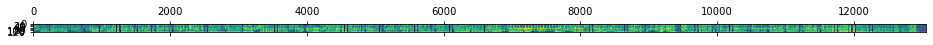

In [ ]:
# Initialize previous prediction to zeros.
# We'll zero out the mask for the first prediction, so the value here doesn't
# matter.
pred_mel = np.zeros([1, synth_model.sequence_length['targets_context'],
                     synth_model.audio_codec.n_dims])

# Variables for accumulating the full song prediction.
full_pred_mel = np.zeros([1, 0, synth_model.audio_codec.n_dims], np.float32)

# Iterators over the dataset.
infer_ds_batches_iter = infer_ds_batches.as_numpy_iterator()

i = 0
while True:
  try:
    batch = next(infer_ds_batches_iter)
    # TODO(fjord): put the first-chunk logic into a library function
    batch['encoder_continuous_inputs'] = pred_mel[:1]
    if i == 0:
      # The first chunk has no previous context.
      batch['encoder_continuous_mask'] = np.zeros_like(
          batch['encoder_continuous_mask'])
    else:
      # The full song pipeline does not feed in a context feature, so the mask
      # will be all 0s after the feature converter. Because we know we're
      # feeding in a full context chunk from the previous prediction, set it
      # to all 1s.
      batch['encoder_continuous_mask'] = np.ones_like(
          batch['encoder_continuous_mask'])
    # it wants batch size divisible by 8 on TPU...
    for key in batch:
      batch[key] = np.tile(batch[key], [8] + [1] * (batch[key].ndim - 1))
    pred_mel, scores = synth_model.predict(batch)
    full_pred_mel = np.concatenate([full_pred_mel, pred_mel[:1]], axis=1)
    i += 1
    print('generated %d segments' % i)
  except StopIteration:
    break

full_pred_audio = synth_model.audio_codec.decode(full_pred_mel)

plt.matshow(np.rot90(full_pred_mel[0]))
play(full_pred_audio)